In [4]:
import os
os.chdir("C:/Users/MDEFSCS4/Documents/GitHub/Hestia_imeche_vision_challenge/NN_recognition_train")

In [5]:
import dataset.square_generation
import matplotlib.pyplot as plt

In [6]:
out_array, coords, letter, color = dataset.square_generation.stitch_random_square("C:/Users/MDEFSCS4/Documents/GitHub/Hestia_imeche_vision_challenge/data/grass_pretrain/frame_birchfields_1_134.jpeg")


In [7]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as k
import glob
from dataset.square_generation import stitch_random_square
from PIL import Image

DATASET_DIR = "C:/Users/MDEFSCS4/Documents/GitHub/Hestia_imeche_vision_challenge/data/grass_pretrain"
TRUE_NEGATIVES_DIR = "C:/Users/MDEFSCS4/Documents/GitHub/Hestia_imeche_vision_challenge/data/true_negatives_pretrain"


STITCH_PROB = 0.5
TRUE_NEG_PRO = 0.2

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


list_of_grass_images = glob.glob(DATASET_DIR + "/*jpeg")
list_of_negative_images = glob.glob(TRUE_NEGATIVES_DIR + "/*jpeg")

def train_generator():
    for i in range(10000):
        if random.random() > TRUE_NEG_PRO:
            if random.random() > STITCH_PROB:
                X, coords, letter, color = stitch_random_square(random.choice(list_of_grass_images))
                presence = 1
                position = [coords["A_X"]/1000,coords["B_X"]/1000,coords["C_X"]/1000,coords["D_X"]/1000,coords["A_Y"]/1000,coords["B_Y"]/1000,coords["C_Y"]/1000,coords["D_Y"]/1000]
                enc_letter = np.zeros(36)
                enc_letter[char_to_int[letter]] = 1
            else:
                img_file = random.choice(list_of_grass_images)
                X = np.array(Image.open(img_file))
                presence = 0
                position = [None,None,None,None,None,None,None,None,]
                enc_letter = np.full(36, None)
        else:
            img_file = random.choice(list_of_negative_images)
            X = np.array(Image.open(img_file))
            presence = 0
            position = [None,None,None,None,None,None,None,None,]
            enc_letter = np.full(36, None)
        # preprocess input for imagenet style
        yield X, (presence, position, enc_letter)

In [48]:
tf_data = tf.data.Dataset.from_generator(train_generator, output_types = (tf.float32,(tf.float32,tf.float32,tf.float32)), output_shapes = ((1000,1000,3),((),(8),(36))))

tf_data = tf_data.prefetch(buffer_size = 200)
tf_data = tf_data.map((lambda image ,Y: (tf.image.resize(image, (224, 224)), Y)))
tf_data = tf_data.map((lambda image ,Y: (tf.image.random_contrast(image, 0.8, 1.2), Y)))
tf_data = tf_data.map((lambda image ,Y: (tf.image.random_brightness(image, 40,), Y)))
tf_data = tf_data.map((lambda image ,Y: (tf.image.random_saturation(image, 0.8, 1.2), Y)))
tf_data = tf_data.map((lambda image ,Y: (tf.image.random_hue(image, 0.05), Y)))

tf_data = tf_data.batch(32)


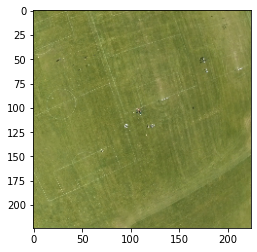

In [52]:
for a,b in tf_data.take(1):
    plt.imshow(a[1,]/255)

In [114]:
a[1,]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[151.74776, 151.53969, 142.94167],
        [155.4001 , 155.20547, 146.675  ],
        [154.83487, 154.63136, 146.05626],
        ...,
        [157.99983, 157.45683, 146.17728],
        [157.28583, 156.85345, 145.46327],
        [165.47008, 165.02719, 153.58427]],

       [[147.02496, 146.8885 , 137.9839 ],
        [155.97594, 155.8644 , 147.0849 ],
        [160.78215, 160.66513, 151.92372],
        ...,
        [159.81685, 159.27385, 147.9943 ],
        [164.96121, 164.51604, 153.06161],
        [165.31212, 164.86694, 153.41252]],

       [[154.94147, 154.95268, 146.13474],
        [164.46567, 164.50146, 155.83168],
        [171.06108, 171.06912, 162.56528],
        ...,
        [159.73563, 159.27568, 147.74715],
        [164.43015, 163.99174, 152.23819],
        [159.21457, 158.77748, 147.08951]],

       ...,

       [[145.9041 , 146.8902 , 135.61574],
        [149.82582, 150.79803, 139.6167 ],
        [152.9535 , 153.966

In [93]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [94]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [105]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_1 = tf.keras.layers.Dense(1)(x)
output_2 = tf.keras.layers.Dense(8)(x)
output_3 = tf.keras.layers.Dense(36)(x)
model = tf.keras.Model(inputs, [output_1, output_2, output_3])

In [106]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.003),
              loss=[tf.keras.losses.BinaryCrossentropy(from_logits=True), tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.CategoricalCrossentropy(from_logits=True)],
              metrics=['accuracy',"mae", "mse"])

In [107]:
model.fit(tf_data)

      1/Unknown - 22s 22s/step

ResourceExhaustedError:  OOM when allocating tensor with shape[384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/mobilenetv2_1.00_224/block_7_expand_BN/FusedBatchNormV3 (defined at <ipython-input-107-e35745518a3f>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_33936]

Function call stack:
distributed_function
